In [2]:
%matplotlib inline

In [3]:
import os
import json
from collections import namedtuple
from itertools import product
import tqdm
import pandas as pd
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=False)

In [28]:
paramSpace = {
    'box-is-light-prior': [.01, .05, .1, .3],
    'subgoal-prior': [.51, .6, .7, .8],
    'use-hand-subgoal-prior': [.51, .6, .7, .8, .9],

    'teaching-weight': [1],
    'randchoose': [0.0],
    'softmax_temp': [0.2],
    'observer-softmax': [.5]
}

paramnames, paramvals = zip(*paramSpace.items())
allfn = os.listdir('simulations')
iteration = tqdm.tqdm(list(product(*paramvals)))
for paramassns in iteration:
    params = dict(zip(paramnames, paramassns))
    param_hash = hash(tuple(sorted(zip(paramnames, paramassns))))
    params['simname'] = str(param_hash).replace('-', '_')
    if (params['simname']+".json" in allfn):
        continue
    json.dump(params, open('sim_config.json', 'w'))
#     paramstr = " ".join([f"--{k} {v}" for k, v in params.items()])
    res = os.system(f'webppl run_sim.wppl --require . --require webppl-json -- --config sim_config.json')
    if res != 0:
        raise Exception("Error")

100%|██████████| 80/80 [01:17<00:00,  1.03it/s]


In [4]:
allfn = os.listdir('simulations')
allsims = []
for fn in allfn:
    if fn == 'kiraly_test.json':
        continue
    simres = json.load(open(f'./simulations/{fn}'))
    for cond in simres['conditions']:
        allsims.append({**cond, **simres['config']})

In [5]:
sims = pd.DataFrame(allsims)
sims["pi(use-head)/pi(use-hand)"] = sims["pi(use-head)"]/sims["pi(use-hand)"]
sims["pi(act)"] = (sims["pi(use-head)"] + sims["pi(use-hand)"])
sims["pi(use-head)/pi(act)"] = sims["pi(use-head)"]/(sims["pi(use-head)"] + sims["pi(use-hand)"])
sims["Q(use-head) - Q(use-hand)"] = sims["Q(use-head)"] - sims["Q(use-hand)"]

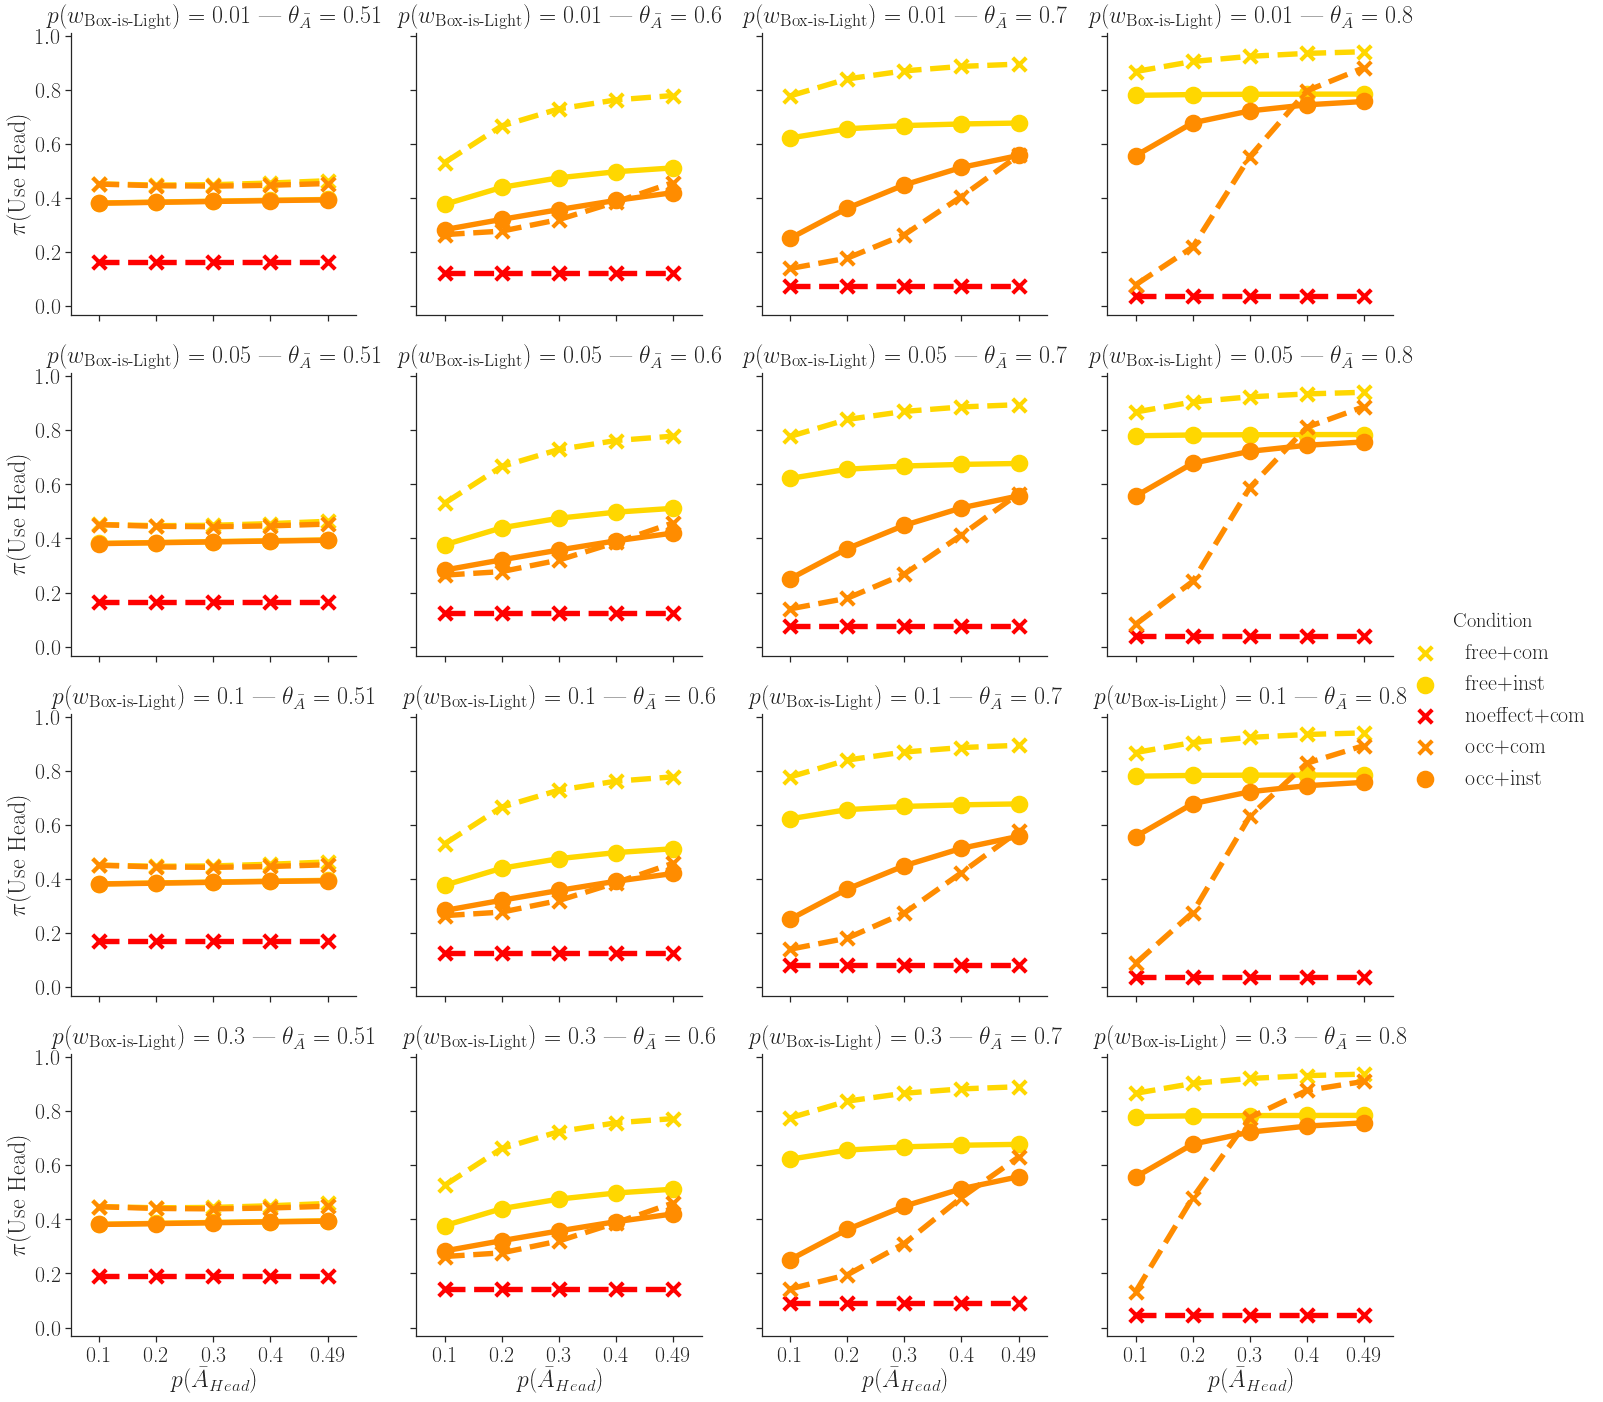

In [7]:
rc('text', usetex=True)
rc("text.latex", preamble=[r'\usepackage{amsmath}'])

sns.set(font_scale=2, style="ticks", font="Times New Roman")

name_order = sorted(sims['name'].unique())
pbarA = r"$\theta_{\bar{A}}$"
sims[pbarA] = sims['subgoal-prior']
priorHead = r"$p(\bar{A}_{Head})$"
sims[priorHead] = np.around(1 - sims['use-hand-subgoal-prior'], 2)
piHead = r"$\pi(\text{Use Head})$"
sims[piHead] = sims['pi(use-head)']
pLight = r"$p(w_\text{Box-is-Light})$"
sims[pLight] = sims["box-is-light-prior"]
sims["Condition"] = sims['name']
g = sns.catplot(
    data=sims,
    x=priorHead, 
    y=piHead,
    hue='Condition', 
    col= pbarA,
    row=pLight,
    kind='point',
    hue_order=name_order,
    palette={n: "gold" if "free" in n else ("darkorange" if "occ" in n else "red") for n in name_order},
    markers=["o" if "inst" in n else 'x' for n in name_order],
    linestyles=['-' if 'inst' in n else '--' for n in name_order],
    scale=2
)
plt.savefig("kiraly_parameters.png", dpi=150)

(0, 0.81)

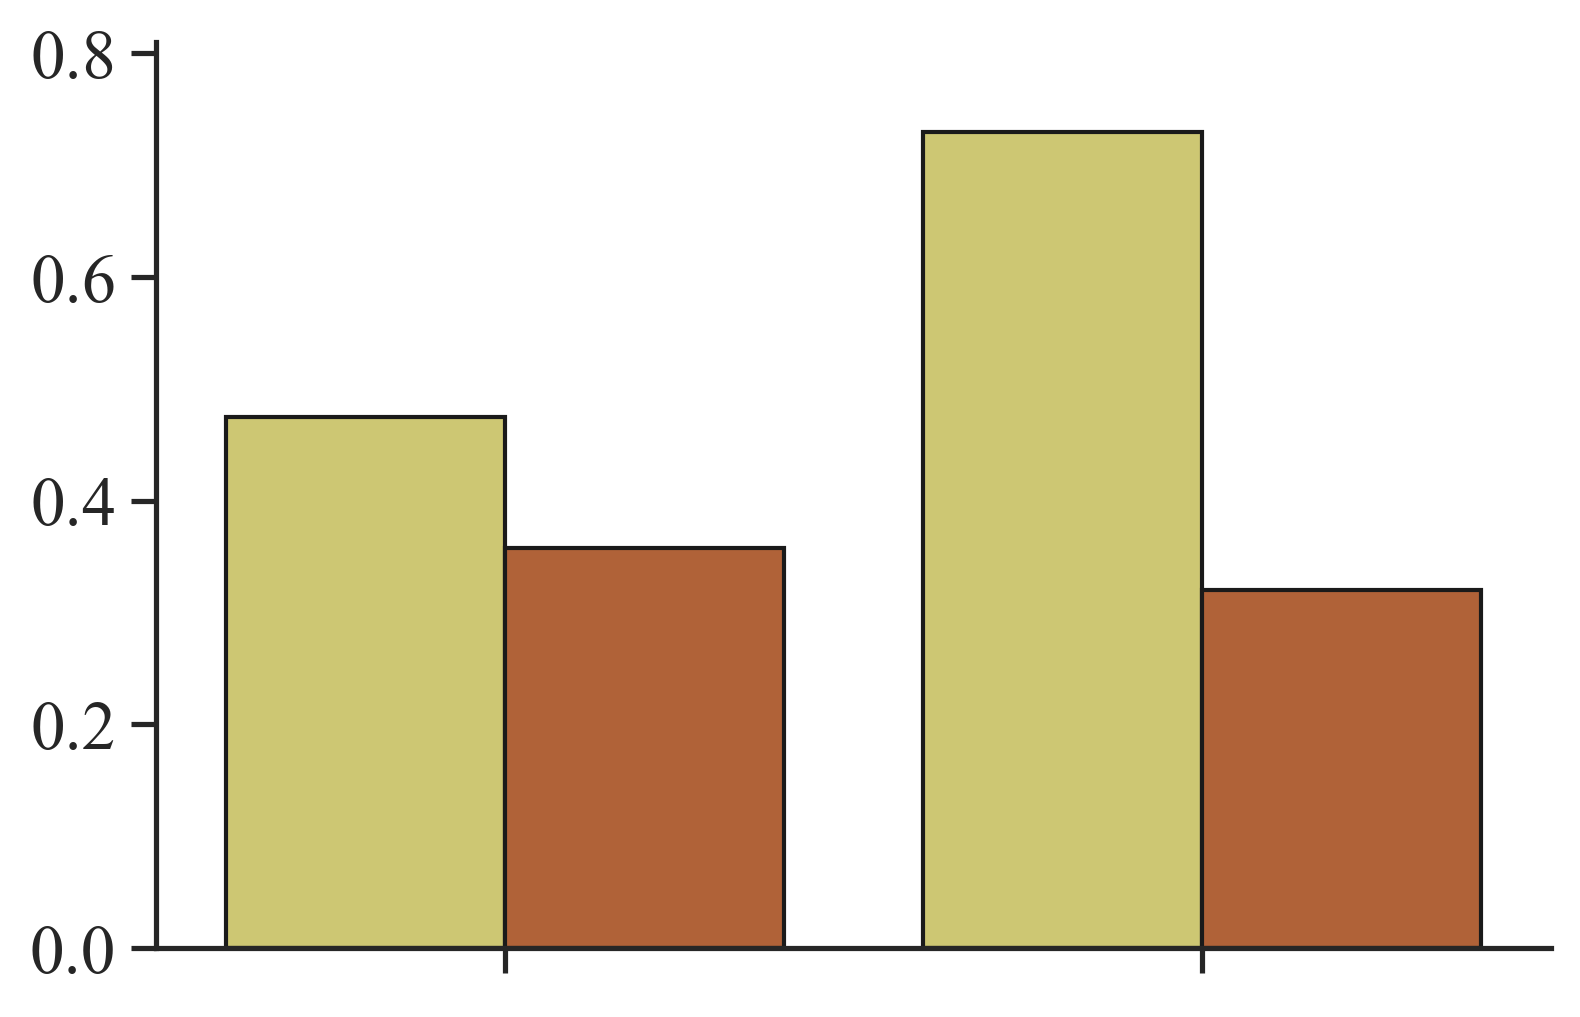

In [51]:
toplot = sims.merge(pd.DataFrame([{
    'box-is-light-prior': .01,
    'subgoal-prior': .6,
    'use-hand-subgoal-prior': .7,

    'teaching-weight': 1,
    'randchoose': 0.0,
    'softmax_temp': 0.2,
    'observer-softmax': .5
}]))
sns.set(font_scale=1.5, style="ticks", font="Times New Roman")
fig, ax = plt.subplots(1, 1, dpi=300)
g = sns.barplot(data=toplot, 
                y="pi(use-head)",
                x='comm', 
                hue='hands',
                hue_order=['free', 'occ'],
                palette=["#dcd464", "#c45c24"],
                order=['inst', 'com'],
                ec='k', lw=1,
                ax=ax
)
g.legend().remove()
sns.despine()
ylab = g.set_ylabel("")
g.set_xlabel("")
g.set_xticklabels(['', ''])
g.set_ylim(0, .81)